# Evaluating AI sourcing tools

In [1]:
%cd ~/ai-sourcing-benchmark/

/home/vslaykovsky/ai-sourcing-benchmark


In [2]:
import pandas as pd
pd.set_option('display.max_columns', 100)

In [ ]:
import glob
import os


def load_search_results():
    out = []
    for f in glob.glob('data/search_results/*.csv'):
        df = pd.read_csv(f)
        df['source'] = {'exa.csv': 'Exa.AI', 'pearch.csv': 'Pearch.AI', 'people.csv': 'PeopleGPT', 'link.csv': 'LinkedIn'}[os.path.basename(f)]
        out.append(df)
    df = pd.concat(out)
    return df

df_sr = load_search_results()
df_sr.head(2)

,query_id,query,search_rank,docid,reranking_group,source
0,49181,I'm looking for a VP or Head of Sales for a he...,0,nick-talone,2.0,PeopleGPT
1,49181,I'm looking for a VP or Head of Sales for a he...,1,jason-de-turris-4b56a933,1.0,PeopleGPT


In [4]:
df_sr.sample(frac=1., random_state=42)['query'].drop_duplicates().head(5).tolist()

['A backend engineer from a top computer science program living in san francisco with 5 years experience working in startups developing performant and scalable backend systems and databases',
 'founders who sold their companies or did an IPO. Only show people from the U.S.',
 'Customer success managers with at least 3 years of experience who are located in the San Francisco Bay Area. I would like them to come from companies that are Series A, Series B, or Series C. They need to have worked in healthcare technology at a SAAS company',
 'engineers with security clearance from top engineering programs. Only show people from the U.S.',
 'looking for a CTO with experience in AI and machine learning, who has also led a team of 50+ developers. Bonus if they have a background in cybersecurity. Only show people from the U.S.']

In [ ]:
overal_stats = df_sr.groupby('source').agg(Queries=('query', lambda v: v.nunique()), TotalResults=('query', len), AveragePerQuery=('query', lambda g: g.value_counts().mean().round(1)))
overal_stats

,Queries,TotalResults,AveragePerQuery
source,,,
Exa.AI,48,465,9.7
LinkedIn,48,465,9.7
Pearch.AI,45,398,8.8
PeopleGPT,42,407,9.7


# Side by side samples

In [6]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

In [7]:
def generate_sbs_samples(df, limit):
    df = df.sample(frac=1.0, random_state=42)
    groups = list(df.groupby(['query', 'search_rank']))
    results = []
    for (q, r), g in groups:
        for i in range(len(g) - 1):
            results.append([q, r] + g.iloc[i].filter(['source', 'docid', 'profile']).tolist() + g.iloc[i+1].filter(['source', 'docid', 'profile']).tolist())
    if 'profile' in df.columns:
        cols = ['query', 'rank', 'source1', 'docid1', 'profile1', 'source2', 'docid2', 'profile2']            
    else:
        cols = ['query', 'rank', 'source1', 'docid1', 'source2', 'docid2']            
    return pd.DataFrame(columns=cols, data=results).sample(frac=1.0, random_state=42).query('source1 != source2').head(limit)


df_sbs = generate_sbs_samples(df_sr, limit=1000)
df_sbs.head(4).reset_index(drop=True)


,query,rank,source1,docid1,source2,docid2
0,"python developer, russian speaking, 7+ years o...",6,PeopleGPT,vegasq,Exa.AI,ana7pana
1,AI strategy consultant with a technical backgr...,4,Exa.AI,anakraftai,LinkedIn,kevinlyonsnyc
2,A backend engineer from a top computer science...,7,PeopleGPT,oleg-petrunya-034a4b1,Pearch.AI,stevenschlansker
3,A perception or computer vision engineer with ...,1,LinkedIn,jayant1408,PeopleGPT,nghia-ho-6259866


In [8]:
from openai import OpenAI

def openrouter(prompt, model="openai/o3-mini"):
    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=os.environ.get("OPENROUTER_API_KEY"),
    )
    completion = client.chat.completions.create(
    model=model,
    messages=[
        {
        "role": "user",
        "content": prompt
        }
    ]
    )
    return completion.choices[0].message.content



In [9]:
import json
import re
import time

def parse_3backticks(answer: str, as_list: bool = False):
    v = re.findall(r"`{3,}\w*((?:(?!```).){2,})`{3,}", answer, re.DOTALL)
    if as_list:
        if len(v) == 0:
            return [answer]
        else:
            return v
    else:
        if len(v) == 0:
            return answer
        else:
            return v[-1]
        
def parse_json(answer):
    data = parse_3backticks(answer, as_list=False)
    return json.loads(data)

def process_row(r):
    for i in range(3):
        try:
            query = r['query']
            prompt = f"""I'll give you a search query for a working professional and two candidate profiles. Your task is to decide which profile is the better match.  
Make sure to consider all specific requirements in the query. Also, check if a candidate is overqualified or underqualified.
Output your decision as JSON: {{
'profile_idx': int # 1 or 2
'summary': str # very short summary explaining the decision
}}

Search query: {query}


Profile 1: {r.profile1}

Profile 2: {r.profile2}"""
            v = openrouter(prompt)
            v = parse_json(v)
            profile_idx = v['profile_idx']        
            return (r.get('source1', 'A') if profile_idx == 1 else r.get('source2', 'B')), v['summary']
        except Exception as ex:
            print(ex)
            time.sleep(1)


def run_llm_sbs(df_sbs, cache_file):
    df_cachehit = pd.DataFrame()
    df_cachemiss = df_sbs
    if os.path.exists(cache_file):
        cache = pd.read_csv(cache_file)
        cache = cache.drop_duplicates(subset=['query', 'docid1', 'docid2']).set_index(['query', 'docid1', 'docid2'])[['LLM winner', 'LLM summary']]
        df_sbs = df_sbs.set_index(['query', 'docid1', 'docid2']).join(cache, how='left').reset_index()

        df_cachemiss = df_sbs[df_sbs['LLM winner'].isna()].copy()
        df_cachehit = df_sbs[~df_sbs['LLM winner'].isna()].copy()
        print('cache miss', len(df_cachemiss), 'cache hit', len(df_cachehit))

    if not df_cachemiss.empty:
        results = []
        with ThreadPoolExecutor(20) as executor:
            futures = [executor.submit(process_row, r) for _, r in df_cachemiss.iterrows()]
            for future in tqdm(futures, total=len(futures), desc="Processing rows"):
                results.append(future.result())
        df_cachemiss['LLM winner'] = [v[0] if v else None for v in results]
        df_cachemiss['LLM summary'] = [v[1] if v else None for v in results]

    df_sbs = pd.concat([df_cachehit, df_cachemiss])
    df_sbs.to_csv(cache_file, index=False)    
    return df_sbs


In [10]:
from elosports.elo import Elo

def sbs_elo(df_sbs, n_samples=100, bootstrap=False, winner_col='LLM winner'):
    results = []
    for smpl in tqdm(range(n_samples), 'Elo samples'):
        eloLeague = Elo(k=20, homefield=False)
        if bootstrap:
            sample_df = df_sbs.sample(n=len(df_sbs), replace=True)
        else:
            sample_df = df_sbs.sample(frac=1.0)
        for player in set(sample_df.source1.unique().tolist() + sample_df.source2.unique().tolist()):
            eloLeague.addPlayer(player)
        for id, r in sample_df.iterrows():
            if r.source1 == r.source2:
                continue
            players = set(r[['source1', 'source2']].tolist())
            
            loser = list(players - set([r[winner_col]]))
            if not loser:
                print(players, r[winner_col], loser, id, r)
            loser = loser[0]
            eloLeague.gameOver(winner=r[winner_col], loser=loser, winnerHome=False)
        results.append(eloLeague.ratingDict)    
    df = pd.DataFrame(results)
    df_mean = df.mean().sort_values()
    df = df[df_mean.index]
    return df

# Human labels

In [11]:

from concurrent.futures import ThreadPoolExecutor
import numpy as np
from tqdm import tqdm


def to_url(docid):
    return f'https://linkedin.com/in/{docid}'


HUMAN_TASKS_DIR = 'data/human_tasks'
GENERATE_HUMAN_TASKS = False
if GENERATE_HUMAN_TASKS:    
    !mkdir -p $HUMAN_TASKS_DIR/anonymized
    !mkdir -p $HUMAN_TASKS_DIR/keys
    df_sbs = generate_sbs_samples(df_sr, limit=1000)
    for idx, g in enumerate(np.array_split(df_sbs.sample(frac=1.0, random_state=42), 10)):
        g['url1'] = g.docid1.apply(to_url)
        g['url2'] = g.docid2.apply(to_url)
        g['winner'] = ''
        g['comment'] = ''
        g[['query', 'url1', 'url2', 'winner', 'comment']].sort_values('query').to_csv(f'{HUMAN_TASKS_DIR}/anonymized/batch_{idx:03d}.csv')
        g.sort_values('query')['query,rank,source1,docid1,source2,docid2,url1,url2,winner,comment'.split(',')].to_csv(f'{HUMAN_TASKS_DIR}/keys/batch_{idx:03d}.csv')        

In [12]:
import pandas as pd
import glob
from tqdm import tqdm 
import re

def extract_info_from_filename(filename):
    pattern = r'data/human_labels/(?P<recruiter>Recruiter[^_]*)_Batch(?P<batch>\d+)(?P<test>_Test)?\.csv'
    match = re.match(pattern, filename)
    if match:
        return match.group('recruiter'), match.group('batch'), match.group('test') is not None
    return None, None, False

def read_human_labels():
    dfs = []
    for f in tqdm(glob.glob('data/human_labels/*.csv'), desc="Reading CSV files"):
        recruiter, batch, is_test = extract_info_from_filename(f)
        df = pd.read_csv(f).fillna('').astype(str)
        df['worker'] = recruiter
        df['batch'] = batch
        df['is_test'] = is_test
        df['docid1'] = df['Candidate A'].apply(lambda v: v.split('/')[-1])
        df['docid2'] = df['Candidate B'].apply(lambda v: v.split('/')[-1])        
        dfs.append(df)    

    df = pd.concat(dfs)
    if 'profile' in df_sr.columns:
        df = df.set_index('docid1').join(df_sr.set_index('docid')[['profile']].drop_duplicates(), how='left').reset_index().rename(columns={'profile': 'profile1'})
        df = df.set_index('docid2').join(df_sr.set_index('docid')[['profile']].drop_duplicates(), how='left').reset_index().rename(columns={'profile': 'profile2'})    
    df.rename(columns={'Query': 'query', 'Winner': 'winner'}, inplace=True)
    df = df[df['winner'] != '']
    df['id'] = df['id'].astype(int)
    df_keys = pd.concat([pd.read_csv(f) for f in glob.glob(os.path.join(HUMAN_TASKS_DIR, 'keys/*.csv'))])
    df = df.set_index('id').join(df_keys.set_index('id')[['source1', 'source2']])
    df['Human winner'] = df.apply(lambda r: r.source1 if r.winner == 'A' else r.source2, axis=1)
    return df.drop(columns=['winner'])


df_human = read_human_labels()
print(len(df_human))
df_human.head(2)

Reading CSV files: 100%|██████████| 17/17 [00:00<00:00, 280.84it/s]

1289


,query,Candidate A,Candidate B,Comment,worker,batch,is_test,docid1,docid2,source1,source2,Human winner
id,,,,,,,,,,,,
303,A backend engineer from a top computer science...,https://linkedin.com/in/chaitanya-pedada-5896b...,https://linkedin.com/in/pernekhan,Selected based on stronger relevant experience...,Recruiter006,006,False,chaitanya-pedada-5896b1147,pernekhan,Pearch.AI,PeopleGPT,Pearch.AI
952,A perception or computer vision engineer with ...,https://linkedin.com/in/neerajpanse,https://linkedin.com/in/keerthirajn,Probable SF-based CV engineer with relevant st...,Recruiter006,006,False,neerajpanse,keerthirajn,PeopleGPT,Exa.AI,PeopleGPT


In [ ]:
df_majority = df_human.query('is_test').groupby(['query', 'Candidate A', 'Candidate B'])['Human winner'].agg(
    lambda x: x.value_counts().idxmax() if x.value_counts().max() > len(x) // 2 else None
).to_frame('Majority vote').dropna()
df_majority.head(2)

,,,Majority vote
query,Candidate A,Candidate B,
"A Boston University (BU) alum that is a head of a department or a founder at an AI first, or AI adjacent company. The company can be losely related to AI or LLMs, or might be working to building out their AI feature set. Only show people from the U.S.",https://linkedin.com/in/shiddharthsaran,https://linkedin.com/in/jconsidi,PeopleGPT
A backend engineer from a top computer science program living in san francisco with 5 years experience working in startups developing performant and scalable backend systems and databases,https://linkedin.com/in/cameron-froehlich-84b86891,https://linkedin.com/in/hanifigunes,Pearch.AI


In [15]:
human_stats = df_human.query('is_test').set_index(['query', 'Candidate A', 'Candidate B']).join(df_majority).reset_index().groupby('worker').apply(
    lambda g: pd.Series({
        'Alignment with Majority Vote': round((g['Majority vote'] == g['Human winner']).mean(), 2),
        'Total Samples': len(g),
        'Total Queries': g['query'].nunique()
    })
).astype({'Total Samples': 'int', 'Total Queries': 'int'}).sort_values(by='Alignment with Majority Vote', ascending=False)
human_stats

/var/tmp/ipykernel_1965739/969588770.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  human_stats = df_human.query('is_test').set_index(['query', 'Candidate A', 'Candidate B']).join(df_majority).reset_index().groupby('worker').apply(


,Alignment with Majority Vote,Total Samples,Total Queries
worker,,,
Recruiter002,0.74,50,32
Recruiter008,0.74,50,32
Recruiter003,0.70,50,32
Recruiter005,0.69,48,31
Recruiter007,0.69,49,31
Recruiter001,0.60,50,32
Recruiter006,0.58,50,32
Recruiter004,0.53,49,31


In [16]:
TOP_HUMANS = human_stats.head(len(human_stats) // 2).index.tolist()
", ".join([f"\textt{{{h}}}" for h in TOP_HUMANS])

'\textt{Recruiter002}, \textt{Recruiter008}, \textt{Recruiter003}, \textt{Recruiter005}'

In [17]:
df_top_human = df_human[df_human.worker.isin(TOP_HUMANS)]

In [18]:
df_result = df_human.query('not is_test').groupby(['worker']).agg(
    Total_labeled_samples=('Human winner', 'count'),
    Total_queries=('query', 'nunique')
).reset_index()
 

df_result

,worker,Total_labeled_samples,Total_queries
0,Recruiter001,100,38
1,Recruiter002,96,42
2,Recruiter003,100,42
3,Recruiter004,99,41
4,Recruiter005,98,40
5,Recruiter006,100,40
6,Recruiter007,200,47
7,Recruiter008,100,42


In [19]:
df_human[['LLM winner', 'LLM summary']] = run_llm_sbs(df_human, 'data/human_sbs.csv')[['LLM winner', 'LLM summary']].values.tolist()


cache miss 0 cache hit 1289


In [22]:
df_human['Alignment with LLM-judge'] = df_human['LLM winner'] == df_human['Human winner']
df_human.groupby(['worker']).agg({
    'Alignment with LLM-judge': 'mean',
    'Human winner': 'count'
}).rename(columns={'Human winner': 'count'}).round(2).sort_values('Alignment with LLM-judge', ascending=False)

,Alignment with LLM-judge,count
worker,,
Recruiter008,0.72,150
Recruiter002,0.71,146
Recruiter005,0.71,146
Recruiter007,0.71,249
Recruiter001,0.67,150
Recruiter003,0.67,150
Recruiter006,0.61,150
Recruiter004,0.49,148


In [23]:
df_regplot = df_human.query('not is_test').groupby('worker')[['Alignment with LLM-judge']].mean().join(human_stats[['Alignment with Majority Vote']]).dropna()

In [24]:
df_regplot

,Alignment with LLM-judge,Alignment with Majority Vote
worker,,
Recruiter001,0.690000,0.60
Recruiter002,0.708333,0.74
Recruiter003,0.640000,0.70
Recruiter004,0.494949,0.53
Recruiter005,0.734694,0.69
Recruiter006,0.620000,0.58
Recruiter007,0.710000,0.69
Recruiter008,0.760000,0.74


Correlation: 0.82, p-value: 0.0137


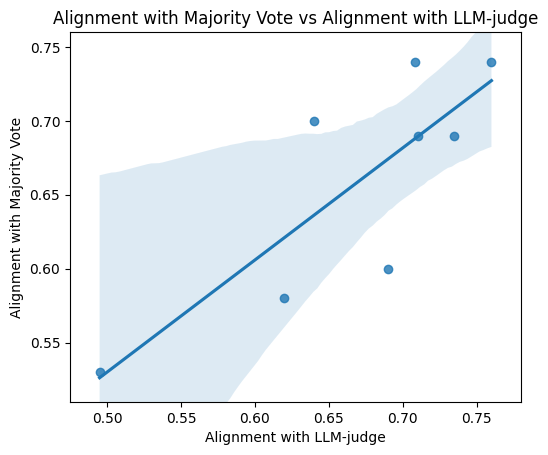

In [25]:

import seaborn as sns
from scipy.stats import pearsonr

gap = 0.02
sns.regplot(
    data=df_regplot,
    x='Alignment with LLM-judge',
    y='Alignment with Majority Vote',
    x_ci='ci',
    ci=95,
    truncate=True,
).set(
    title='Alignment with Majority Vote vs Alignment with LLM-judge',
    aspect='equal',
    xlim=(df_regplot['Alignment with LLM-judge'].min() - gap, df_regplot['Alignment with LLM-judge'].max() + gap),
    ylim=(df_regplot['Alignment with Majority Vote'].min() - gap, df_regplot['Alignment with Majority Vote'].max() + gap)
)

# Calculate and print correlation statistics
correlation, p_value = pearsonr(df_regplot['Alignment with LLM-judge'], df_regplot['Alignment with Majority Vote'])
print(f"Correlation: {correlation:.2f}, p-value: {p_value:.4f}")


## Disagreement analysis

In [31]:
df_dis = df_human.set_index(['query', 'Candidate A', 'Candidate B']).join(
    df_majority
)

In [56]:
import json
import pandas as pd

pd.set_option('display.max_colwidth', 1000)

def compute_comments(group):
    # Determine the majority vote for the group
    maj_vote = group['Majority vote'].iloc[0]
    llm_vote = group['LLM winner'].iloc[0]
    # Filter comments based on whether the vote matches the group's majority vote
    majority_comments = group.loc[group['Human winner'] == maj_vote, 'Comment'].tolist()
    minority_comments = group.loc[group['Human winner'] != maj_vote, 'Comment'].tolist()
    
    return pd.Series({
        'majority_vote': maj_vote,
        'human_majority_comments': json.dumps(majority_comments),
        'human_minority_comments': json.dumps(minority_comments),
        'llm_winner': group['LLM winner'].iloc[0],
        'llm_comment': group['LLM summary'].iloc[0]
    })

# Filter out rows where 'Majority vote' equals 'LLM winner', then group and apply the function
result = df_dis.dropna().query('`Majority vote` != `LLM winner`') \
    .groupby(['query', 'Candidate A', 'Candidate B']) \
    .apply(compute_comments)

result.to_csv('data/disagreement.csv')


# Win-rate matrix + Elo

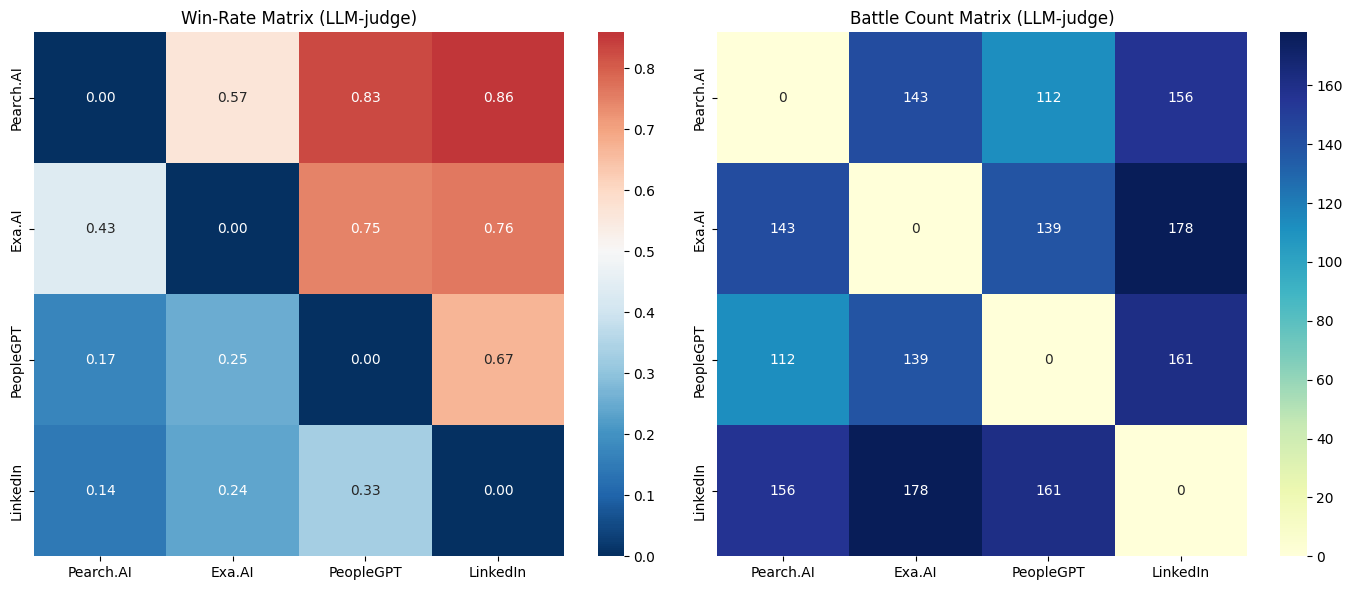

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_win_rate_and_battle_count_heatmaps(df, winner_col='LLM winner', source1_col='source1', source2_col='source2', title_suffix=''):
    # Get all unique sources from both columns
    sources = list(set(df[source1_col]).union(set(df[source2_col])))
    
    # Initialize the win-rate matrix and battle-count matrix
    win_rate = pd.DataFrame(index=sources, columns=sources, dtype=float)
    battle_count = pd.DataFrame(index=sources, columns=sources, dtype=float)
    
    # Compute win-rate and battle count for each pair of sources
    for i in sources:
        for j in sources:
            if i == j:
                win_rate.loc[i, j] = 0.0  # Baseline for identical sources
                battle_count.loc[i, j] = 0
            else:
                # Select matches between source i and source j (order independent)
                mask = (((df[source1_col] == i) & (df[source2_col] == j)) |
                        ((df[source1_col] == j) & (df[source2_col] == i)))
                matches = df[mask]
                total_matches = len(matches)
                battle_count.loc[i, j] = total_matches
                if total_matches > 0:
                    # Count wins for source i
                    wins = (((matches[source1_col] == i) & (matches[winner_col] == i)) |
                            ((matches[source2_col] == i) & (matches[winner_col] == i))).sum()
                    wr = wins / total_matches
                    win_rate.loc[i, j] = wr
                else:
                    win_rate.loc[i, j] = np.nan
    
    # Order rows and columns by the average win-rate (ignoring NaN)
    order = win_rate.mean(axis=1).sort_values(ascending=False).index
    win_rate = win_rate.loc[order, order]
    battle_count = battle_count.loc[order, order]
    
    # Create subplots: left for win-rate matrix and right for battle count matrix
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot win-rate heatmap
    sns.heatmap(win_rate, annot=True, fmt=".2f", cmap="RdBu_r", center=0.5, cbar=True, ax=axes[0])
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    axes[0].set_title(f'Win-Rate Matrix{title_suffix}')
    
    # Plot battle-count heatmap with fmt adjusted to handle float values without decimals
    sns.heatmap(battle_count, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True, ax=axes[1])
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[1].set_title(f'Battle Count Matrix{title_suffix}')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_win_rate_and_battle_count_heatmaps(df_human.query('not is_test'), title_suffix=' (LLM-judge)')


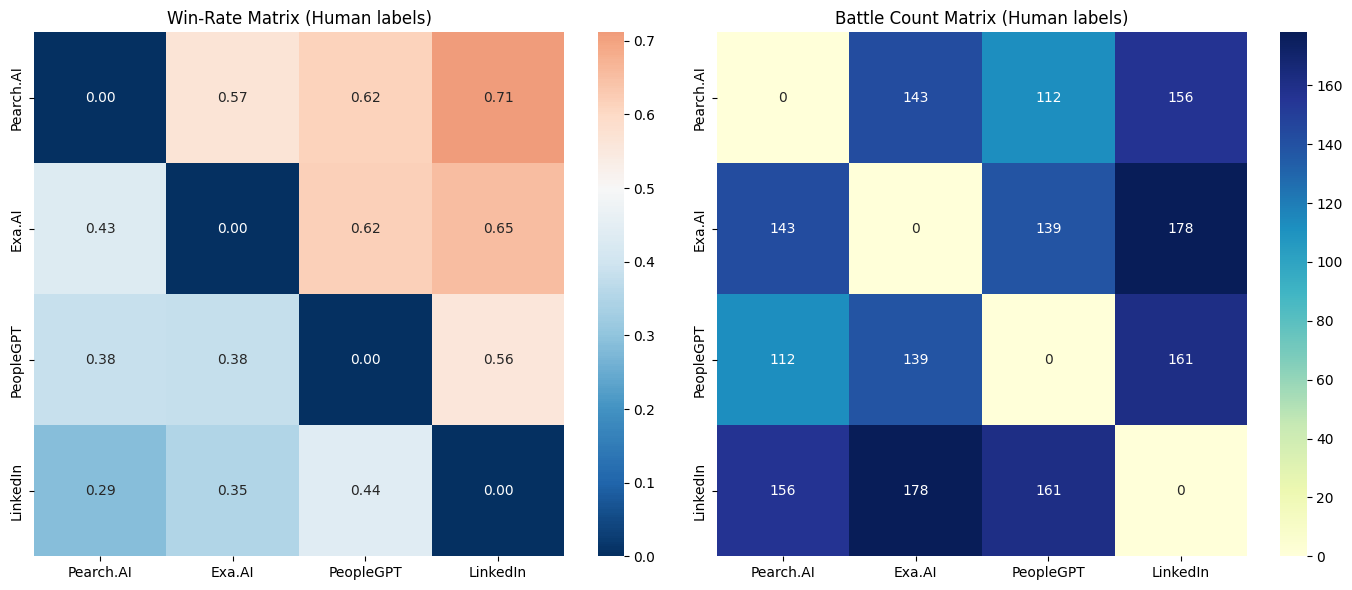

In [24]:
plot_win_rate_and_battle_count_heatmaps(df_human.query('not is_test'), winner_col='Human winner', title_suffix=' (Human labels)')


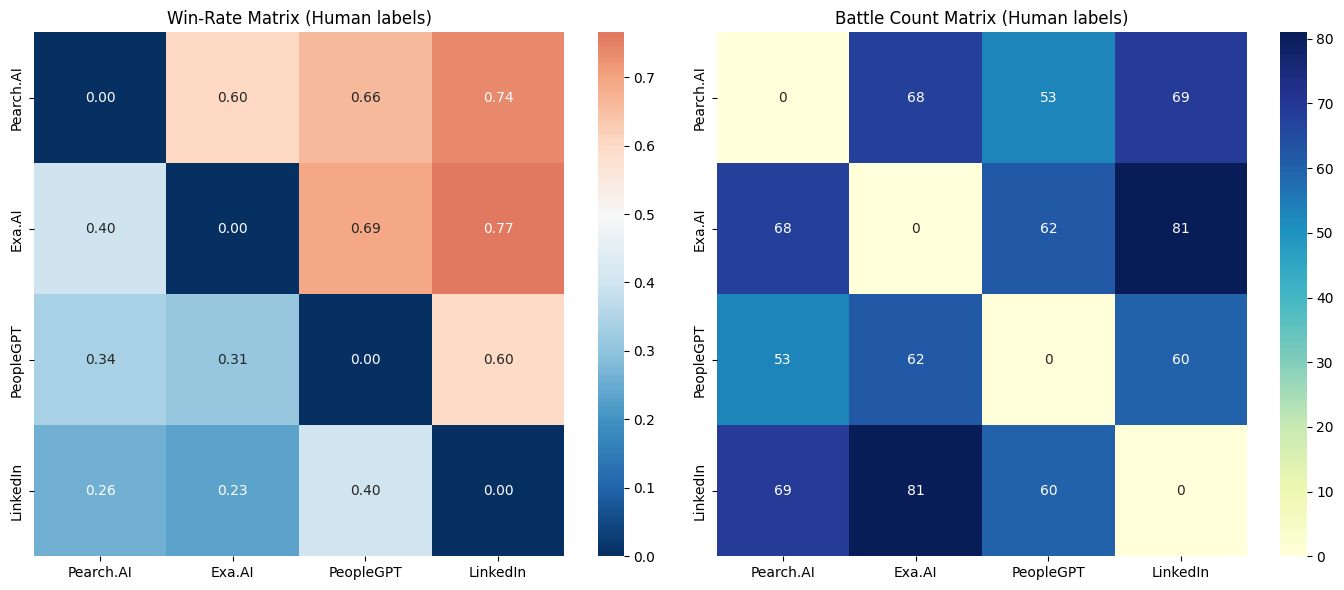

In [25]:
plot_win_rate_and_battle_count_heatmaps(df_human.query('not is_test and worker in @TOP_HUMANS'), winner_col='Human winner', title_suffix=' (Human labels)')


Elo samples:   0%|          | 0/100 [00:00<?, ?it/s]

Elo samples: 100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


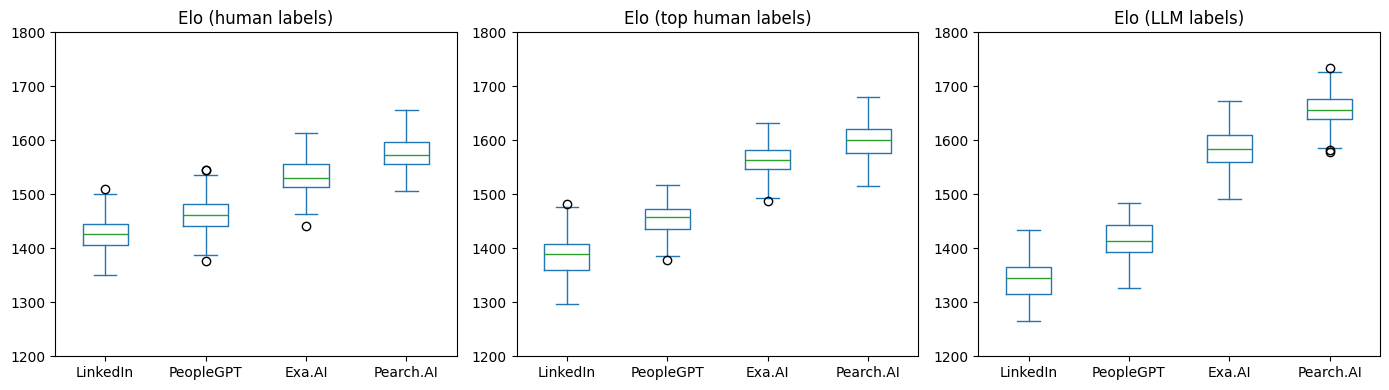

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

smpls = 100
ylim = (1200, 1800)
sbs_elo(
    df_human.query('not is_test'),
    bootstrap=False,
    n_samples=smpls,
    winner_col='Human winner'
).plot.box(ylim=ylim, title='Elo (human labels)', ax=axes[0])

sbs_elo(
    df_top_human.query('not is_test'),
    bootstrap=False,
    n_samples=smpls,
    winner_col='Human winner'
).plot.box(ylim=ylim, title='Elo (top human labels)', ax=axes[1])

sbs_elo(
    df_human.query('not is_test'),
    bootstrap=False,
    n_samples=smpls,
    winner_col='LLM winner'
).plot.box(ylim=ylim, title='Elo (LLM labels)', ax=axes[2])

plt.tight_layout()
plt.show()


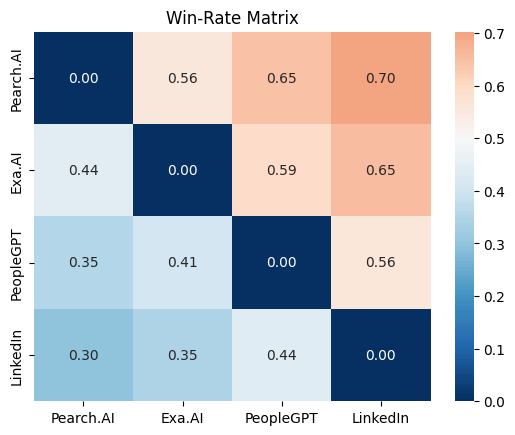

In [46]:
from elosports.elo import Elo
import pandas as pd

def elo_win_rate_matrix(df_sbs, winner_col='Human winner', run_n_times=30):
    aggregated_matrix = None
    
    for _ in tqdm(range(run_n_times), desc="Elo Simulation Progress"):
        eloLeague = Elo(k=20, homefield=False)
        sample_df = df_sbs.sample(frac=1.0)
        
        # Add players to the Elo league
        for player in set(sample_df.source1.unique().tolist() + sample_df.source2.unique().tolist()):
            eloLeague.addPlayer(player)
        
        # Process each match result
        for id, r in sample_df.iterrows():
            if r.source1 == r.source2:
                continue
            players = set(r[['source1', 'source2']].tolist())
            loser = list(players - set([r[winner_col]]))
            if not loser:
                print(players, r[winner_col], loser, id, r)
            loser = loser[0]
            eloLeague.gameOver(winner=r[winner_col], loser=loser, winnerHome=False)
        
        # Create win-rate matrix
        players = list(eloLeague.ratingDict.keys())
        win_rate_matrix = pd.DataFrame(index=players, columns=players, data=0.0)
        
        for player1 in players:
            for player2 in players:
                if player1 != player2:
                    expected_win_rate = eloLeague.expectResult(eloLeague.ratingDict[player1], eloLeague.ratingDict[player2])
                    win_rate_matrix.loc[player1, player2] = expected_win_rate
        
        # Aggregate matrices
        if aggregated_matrix is None:
            aggregated_matrix = win_rate_matrix
        else:
            aggregated_matrix += win_rate_matrix
    
    # Average the matrices
    averaged_matrix = aggregated_matrix / run_n_times
    
    # Order rows and columns by average win rate
    averaged_matrix['average'] = averaged_matrix.mean(axis=1)
    averaged_matrix = averaged_matrix.sort_values(by='average', ascending=False).drop(columns='average')
    averaged_matrix = averaged_matrix.loc[averaged_matrix.index, averaged_matrix.index]  # Reorder columns to match the order of rows
    
    return averaged_matrix

win_rate_matrix = elo_win_rate_matrix(df_human.query('not is_test'))



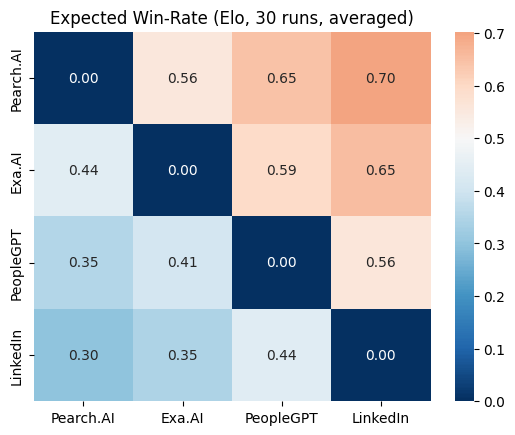

In [50]:

# Plot win-rate heatmap
# plt.figure(figsize=(10, 8))
plt.title('Expected Win-Rate (Elo, 30 runs, averaged)')
sns.heatmap(win_rate_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0.5, cbar=True)
plt.xlabel('')
plt.ylabel('')
plt.show()